# Spatial Analysis and Modeling

### Instructor: Rossano Schifanella
Email: [rossano.schifanella@unito.it](mailto:rossano.schifanella@unito.it)

This tutorial has been from a post of Andrew Gaidus.


# Modeling San Francisco Crime Rates: A Spatial Econometric Approach

In the following notebook, I walk through the steps required to build, evaluate, and interpret spatial regression models in Python. 

I start with some background on maximum likelihood spatial regression models and then use the Python library ```pysal``` to implement them. Based on the data I found freely available, I have decided to do an analysis of crime rates within block groups in San Francisco.  

The goal here is to develop a model that examines the relationship between rate of drunkenness incidents and bar density within block groups, while controlling for underlying spatial structure as well as for other block group characteristics that tend to be related to crime (Freisthler et al, 2016).  The explanatory variables I use in these models (in addition to bar density) are % poverty, % male, % vacant housing units, and retail density. The inclusion of retail density as a control is important in that it helps separate the effect of bars from the overall effect of retail, which tends to have a positive relationship with crime.  

Before I start, I do want to point out some caveats and offer some words of caution. Firstly, these are far from finished statistical models. I'm using them as an example of how to deal with issues that arise when modeling spatial data, and have thus chosen not to consider other non-spatial issues that could potentially bias the results - heteroskedasticity, non-linear relationships, etc. 

Secondly, the types of models that I am considering are only one class of spatial econometric models. There are much more advanced ways of modeling spatial data such as conditional autoregressive models, Bayesian spatial models, non-linear spatial models, etc. This, however, is outside of the scope of this introductory analysis. Lesage and Pace, 2009 provides a great overview of these different types of models. 

And lastly, there could be issues with the underlying question that I'm asking, having to do with that fact that I have actually no idea what a "drunkeness" incident really is. I'm choosing to not worry about this as I'm primarily interested in showing the statistical processes rather than offer any practical evaluation of crime in San Francisco. Nonetheless, I think it'd be interesting to see if this relationship that makes somewhat intuitive sense will actually manifest itself in the police data.

## Spatial Regression Background

The class of spatial regression models I'm covering is a subset of regression models that deals with two main types of spatial patterns - spatial autocorrelation and spatial heterogeneity. There are two basic types of spatial regression models, each of which addresses one of these types of spatial patterns (Lesage and Pace, 2009) 

### Spatial Lag Model
The spatial lag model primarily addresses spatial autocorrelation. Spatial autocorrelation, in this context, refers to the case when our dependent variable exhibits a non-random pattern over our spatial units after controlling for other covariates. Positive autocorrelation  reflects value similarity in space, and negative autocorrelation reflects value dissimilarity in space. The mechanism here is that the outcome measure itself exhibits some force (either one of attraction or repulsion) on the outcome measure of nearby units.

The spatial lag model takes the same approach that temporal autoregressive models take, except rather than including a temporal lag of the dependent variable as a predictor, it includes a spatial lag of the dependent variable (average value in neighboring units). The idea here is that the outcome in a given block group will depend not only on the characteristics of that block group, but also on the outcome in adjacent block groups. The spatial lag model looks just like the standard OLS model with an added autoregressive term: 
$$Y = \rho W_Y + X \beta + \epsilon $$

$Y$ is the outcome measure, $\rho$ is a spatial autoregressive term $W_Y$ is the spatial lag of the dependent variable, $X$ is the matrix of explanatory variables, and $\epsilon$ is a vector of error terms assumed as $\epsilon \sim N(0,\sigma^2 I)$

### Spatial Error Model
The spatial error model primarily addresses spatial heterogeneity, or spatial interactions in the model that are a result of omitted variables that are spatially autocorrelated. It also looks like the standard OLS regression although now the error term is parsed apart into a spatial component and a non-spatial component.

$$Y = X \beta + \epsilon $$

$$\epsilon = \lambda W \epsilon + \mu$$
$$\mu \sim N(0,\sigma^2 I)$$

$\lambda$ is the spatial autoregressive term, $W$ is the adjacency matrix, and $\mu$ is the non-spatial, random error component.

Generally, data does not fall neatly into one of these two categories and can possess spatial autoregressive properties both in the outcome measure and in the error terms. Fortunately, there are lagrange multiplier tests that can help us determine which form of autoregression is of primary concern and which model would be most appropriate.


### Spatial Regression Steps
The following are the general set of steps that I take when running one of these spatial regression models.
1. Build adjacency matrix and define criteria of defining links between geographic units
2. Assign weights to these links
3. Exploratory analysis - examine relationships and measure spatial autocorrelation
4. Run OLS regression and use that to inform the type of spatial regression that will be used
5. Run spatial regression

Now I will go ahead and import the necessary Python libraries and read in my data!

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Modern PySAL split packages
import libpysal as lps     # weights, graphs, IO utilities
import esda                # Moran's I, LISA, etc.
import spreg               # spatial regression

%config InlineBackend.figure_format = 'retina'

In [4]:


data = pd.read_csv('data/incidents/InputDataset.csv', dtype={'BGFIPS10': object}).set_index('BGFIPS10')
geo = gpd.read_parquet('data/incidents/SF_BlockGroups10.parquet').set_index('BGFIPS10')

gdf = gpd.GeoDataFrame(data, geometry=geo.geometry)

## 1 - Building Spatial Adjacency Matrix
The adjacency matrix is key to any spatial regression. It defines the relationships between the units of analysis so that the model can control for the fact that areas that are near to each other are more similar than areas that are far apart. There are many ways of defining neighbors, such as distance based methods (k nearest neighbors, distance specified) and contiguity methods (queen, rook) (Anselin and Rey, 2014).

Below, I create two different contiguity-based weights matrices (rook and queen) from my input block group shapefile. Rook adjacency neighbors are defined as those that share a common edge, and queen adjacency neighbors are defined as those that share a common edge or node. The number of links created in a queen matrix will always be at least as large as the number from a rook matrix.  The code below creates ```pysal``` weights objects which can that be applied directly as a parameter in a regression model or studied on their own to look at neighbor properties.

In [5]:
import libpysal as lps

# Build contiguity weights directly from the GeoDataFrame to avoid deprecated shapefile readers
rook_w = lps.weights.contiguity.Rook.from_dataframe(geo, ids=geo.index)
queen_w = lps.weights.contiguity.Queen.from_dataframe(geo, ids=geo.index)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 060759804011.
  W.__init__(self, neighbors, ids=ids, **kw)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 060759804011.
  W.__init__(self, neighbors, ids=ids, **kw)


In the example below, I extract block group 060750103003 and show that it has 4 rook neighbors and 7 queen neighbors. Queen contiguity distance weights are probably the most common weights matrices used in these types of analyses, and will be what I choose to use going forward.

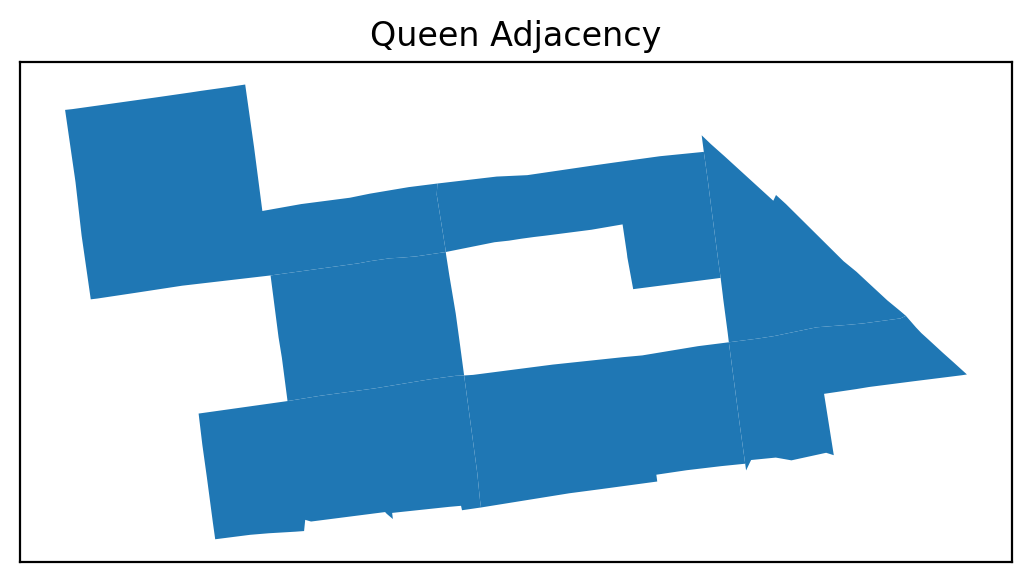

In [6]:
queen_neighs=queen_w.neighbors['060750103003']
q=geo.loc[queen_neighs].plot()
q.set_xticks([])
q.set_yticks([])
title=plt.title('Queen Adjacency')

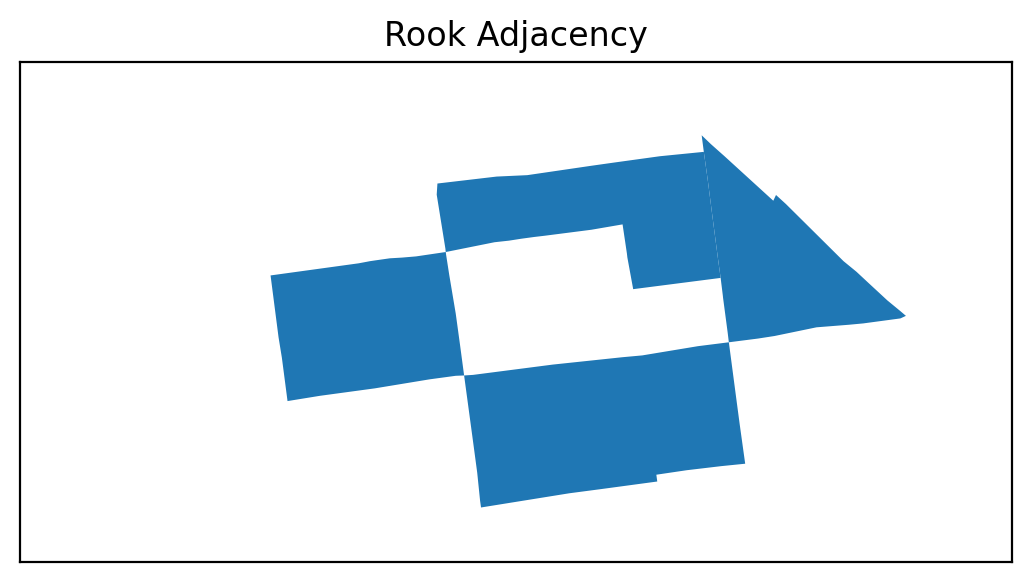

In [7]:
rook_neighs=rook_w.neighbors['060750103003']
r=geo.loc[rook_neighs].plot()
r.set_xticks([])
r.set_yticks([])
a=plt.axis(q.axis())
title=plt.title('Rook Adjacency')

### Identifying Unusual Block Groups Based on Neighbor Counts
Now that the adjacency matrix is built, I can examine some characteristics of the links formed by the 580 block groups in San Francisco. Below I plot a histogram of the number of neighbors. As you can see, the median number of neighbors for these units is somewhere around 6. Two oddities that we can see here are that there is one block group with 0 neighbors and one block group with 35(!) neighbors. I examine these further below.

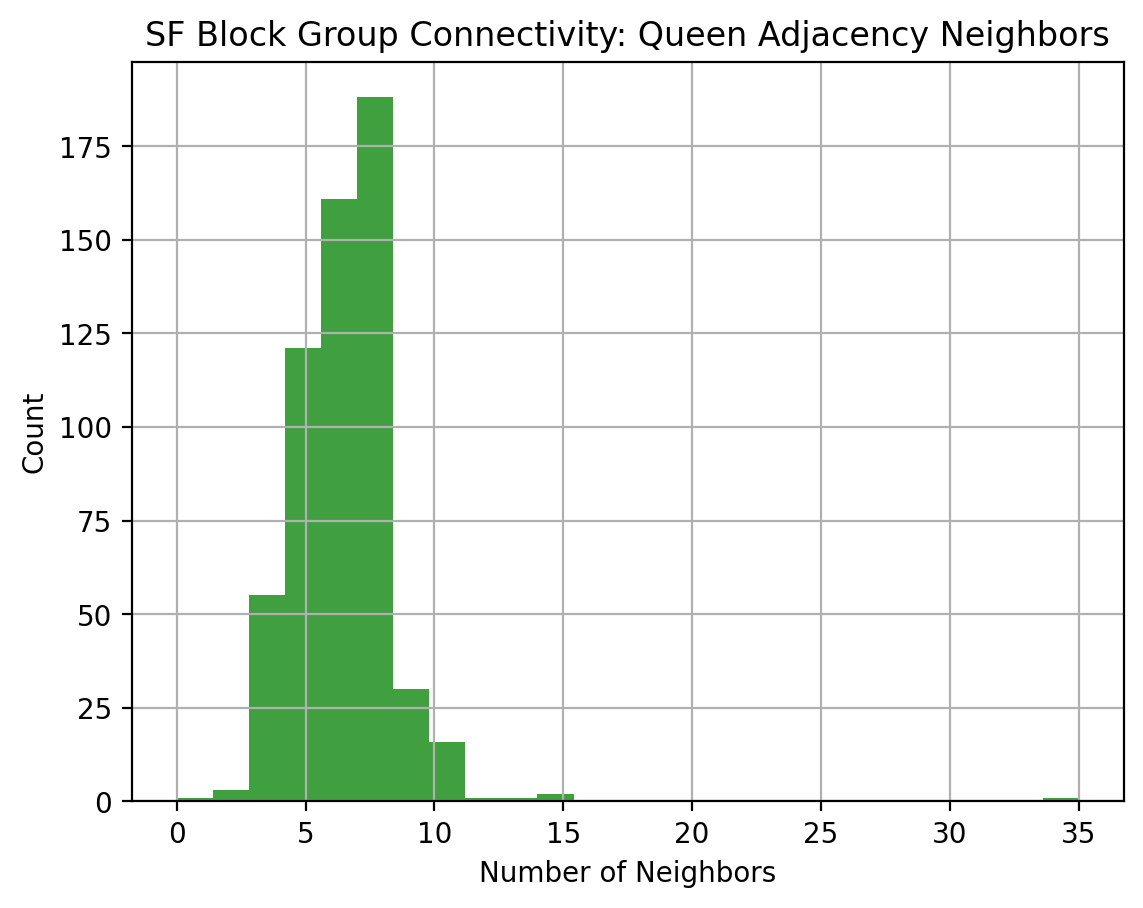

In [8]:
n, bins, patches = plt.hist(queen_w.cardinalities.values(), 25, facecolor='green', alpha=0.75)

plt.xlabel('Number of Neighbors')
plt.ylabel('Count')
plt.title('SF Block Group Connectivity: Queen Adjacency Neighbors')
plt.grid(True)

I can easily identify my "island" block group by selecting for the block group with 0 neighbors. If you are familiar with San Francisco, you may recognize these as the Farallon Islands, which are a group of uninhabited islands 30 miles off the coast. Given that this is not your typical area within San Francisco, I will drop it from the analysis. However, in general, areas with no neighbors *could* still be included in a spatial regression model, although they would receive no spatial weight and therefore would be defined as having no relationship to any other geographic units.

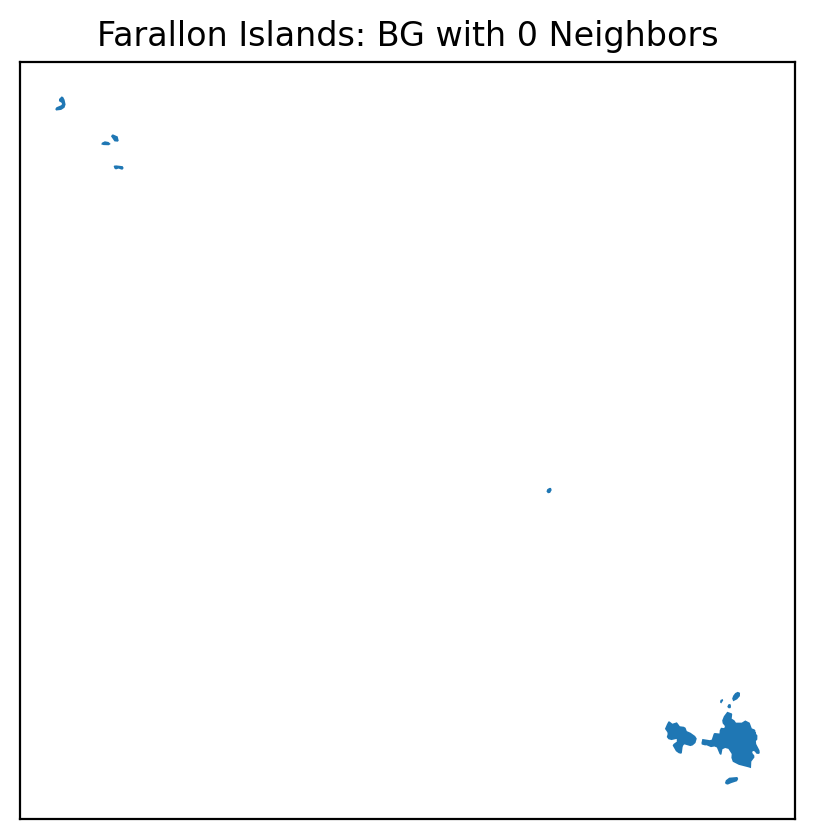

In [9]:
islandid=[k for k,v in queen_w.cardinalities.items() if v==0][0]

f, ax = plt.subplots(figsize=(5,5))
gpd.GeoSeries(geo.loc[islandid]).plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.set_title('Farallon Islands: BG with 0 Neighbors')
plt.show()

From the histogram you can also see that there is a huge outlier - a block group that has 35 neighbors. I must say, I was initially very confused by this, although after some further exploration it became quite clear: Golden Gate Park! I plot this block group below along with its many adjacent block groups. Golden Gate Park, too, is not your typical area within San Francisco, and will likely cause some weird results in this analysis since it has 0 people, yet still plenty of crime. I go ahead and remove the Farallon Islands and Golden Gate Park from the dataset.

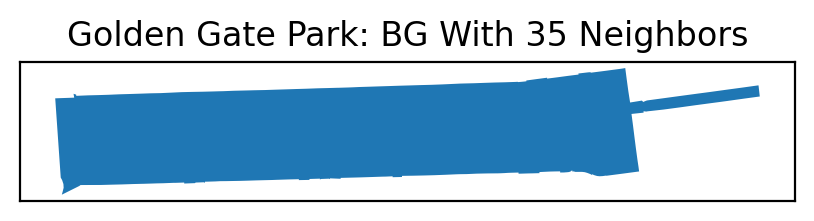

In [10]:
idmax=pd.Series(queen_w.cardinalities).idxmax()
f, ax = plt.subplots(figsize=(5,5))
p=geo.loc[[idmax]].plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
t = ax.set_title('Golden Gate Park: BG With 35 Neighbors')

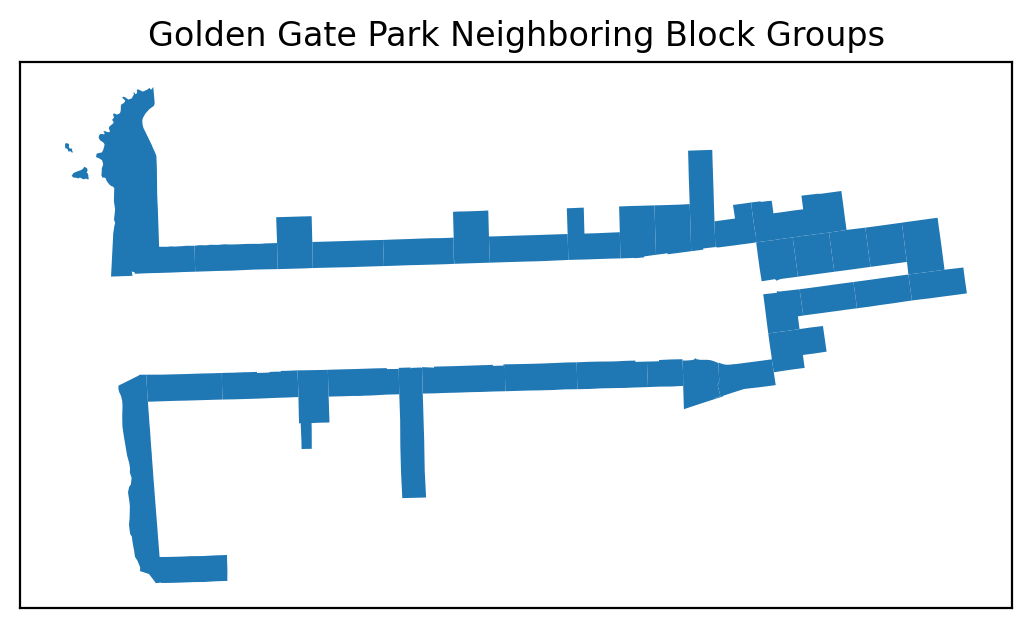

In [11]:
neigh_ids=queen_w.neighbors[idmax]
p=geo.loc[neigh_ids].plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Golden Gate Park Neighboring Block Groups')

And while I'm removing unusual block groups from the analysis, there is one more odd ball that I noticed and will remove. Evidently there is one block group that is a multipart geometry made of 10 different polygons. This one block group represents all of the islands in the San Francisco Bay (Alcatraz, Angel Island, Treasure Island, Yerba Buena Island) as well as some of the piers along Embarcadero. Because the piers along Embarcadero do have neighbors, this block group does not show up as being an 'island' in our adjacency matrix. Given that this block group encompasses such a wide range of places, some of which have true neighbors and some of which do not, I will also drop it from the study.

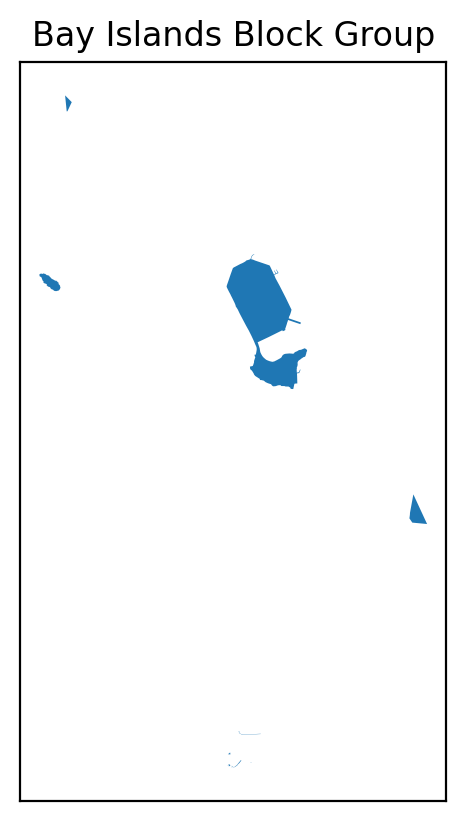

In [12]:
bay_islands='060750179021'
p=geo.loc[[bay_islands]].plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Bay Islands Block Group')

I remove these 3 block groups from the dataset and export it as a new shapefile that I create an updated weights matrix from.

In [ ]:
data = data[~data.index.isin([idmax, islandid, bay_islands ])]
geo = geo[~geo.index.isin([idmax, islandid, bay_islands])]

# Export a modern GeoParquet instead of a shapefile for future reuse
try:
    geo.reset_index().to_parquet('Data/SF_BlockGroups10_Cleaned.parquet', index=False)
except Exception as e:
    print(f"Warning: could not write GeoParquet cleaned copy: {e}")

gdf = gpd.GeoDataFrame(data, geometry=geo.geometry)

# Build weights from the cleaned GeoDataFrame
w = lps.weights.contiguity.Queen.from_dataframe(geo, ids=geo.index)

<Axes: >

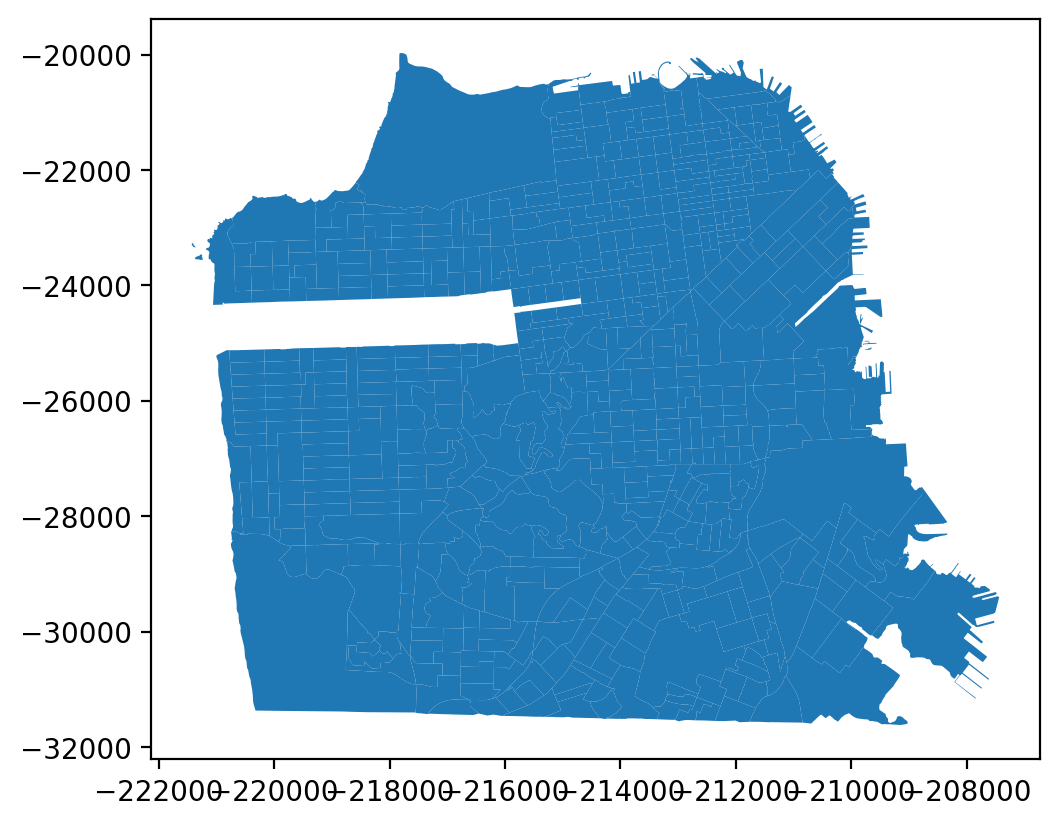

In [ ]:
gdf.to_parquet('data/incidents/SF_BlockGroups10_Cleaned.parquet', index=True)

## 2-  Assigning Spatial Weights to Neighbor Links

Now that the links of neighbors in the dataset have been defined, the next step is to define how these links will be weighted. When a weights matrix is created in ```pysal``` it initially comes with binary weights, which just indicates each neighbor with a weight of 1. With binary weights each neighbor contributes the same amount regardless of how many neighbors the unit has. The more standard approach is to row-standardize weights by dividing by the number of neighbors. A block group with 4 neighbors will each be weighted at 25%. Below, I show binary and row-standardized weights for a sample block group in the dataset. In general it makes sense to use row-standardized weights, which is what I do going forward.

In [14]:
print('Binary weights:')
print(w[list(w.weights.keys())[0]])

Binary weights:
{'060750102001': 1.0, '060750103001': 1.0, '060750101002': 1.0, '060750105001': 1.0}


In [15]:
print('Row-standardized weights:')
w.transform = 'r'
print(w[list(w.weights.keys())[0]])

Row-standardized weights:
{'060750102001': 0.25, '060750103001': 0.25, '060750101002': 0.25, '060750105001': 0.25}


In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Modern PySAL split packages
import libpysal as lps     # weights, graphs, IO utilities
import esda                # Moran's I, LISA, etc.
import spreg               # spatial regression

# Optional: high-DPI figures in notebooks
%config InlineBackend.figure_format = 'retina'

## 3 - Exploratory Analysis

Before running the initial regression models, there are a few other exploratory steps I want to take to make sure I understand the data. The first is a simple scatter plot of the outcome measure (rate of drunk incidents) against the main explanatory variable of interest (bar density). I use ```numpy``` to fit a quick regression line to add to the scatter plot along with the equation of the line. As you can see, there does appear to be a small positive relationship between these two variables (0.097). This means that an increase in 10 bars per square mile is associated with an increase in approximately 1 drunk accident per 1000 people. The question is whether or not this relationship is significant, and if so, whether it will hold when I control for other block group characteristics, as well as the  underlying spatial structure of these variables.

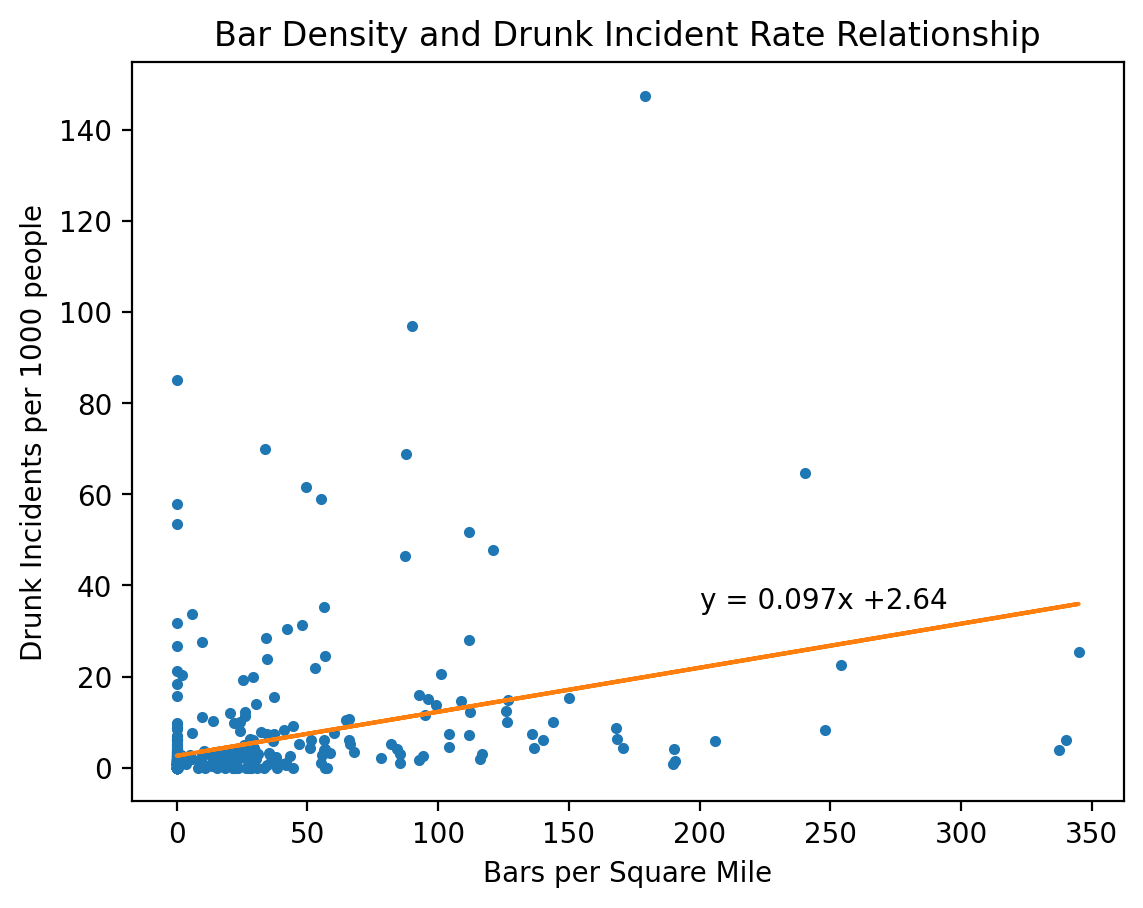

In [17]:
x=data.BarPSqMi
y=data.DrunkP1k
m, b = np.polyfit(x,y,1)

ax=plt.plot(x, y, '.')
f=plt.plot(x, m*x + b, '-')
plt.ylabel('Drunk Incidents per 1000 people')
plt.xlabel('Bars per Square Mile')

formula='y = '+str(m.round(3))+'x +'+str(b.round(2))
plt.text(200, 35, formula)

title=plt.title('Bar Density and Drunk Incident Rate Relationship')

My next exploratory step is to check for spatial autocorrelation in my outcome measure. The spatial distribution of this variable is far from random - the whole eastern part of the city (especially around Market Street) appears to be a hotspot, whereas the western part of the city has much lower rates. A Global Moran's I statistic tests for spatial autocorrelation and ranges from -1 (dispersed) to 1 (clumped). I run this test statistic below (the tool takes a vector of values and a weights object as its inputs). The Moran's coefficient is positive and highly significant (0.384018, p-value=0.0) indicating that our outcome measure is indeed spatially autocorrelated.

This in itself is not necessarily a problem. Simply including other covariates in the model, as would be done in a standard OLS regression, will control for some of this spatial pattern as areas with higher rates presumably have higher rates for some underlying reason that we are modeling. However, if we see spatial autocorrelation in the model residuals (after including our covariates), that indicates a problem and is a violation of the standard assumptions of OLS, which is that our errors are I.I.D. (independently and identically distributed).

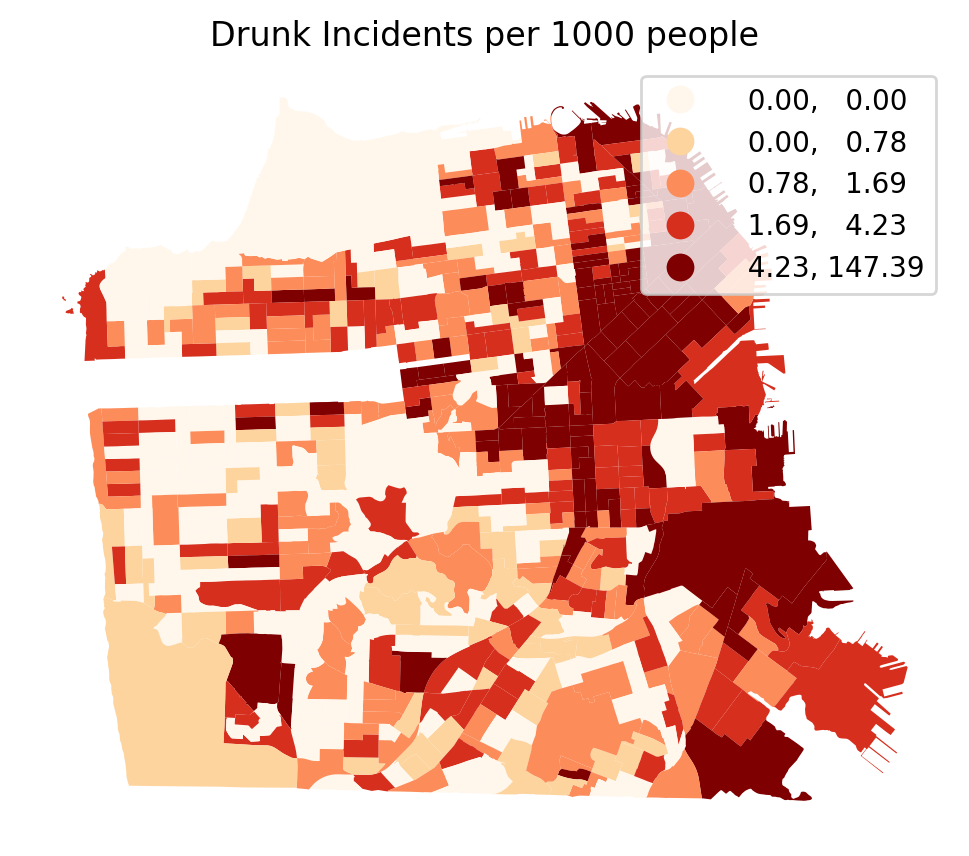

In [18]:
f, ax = plt.subplots(figsize=(6,6))
ax.set_title('Drunk Incidents per 1000 people')
ax.set_axis_off()
_ = gdf.plot(ax = ax, column='DrunkP1k', scheme='QUANTILES', cmap='OrRd', legend=True)

In [19]:
mi = esda.Moran(y, w)
pd.Series(index=['Morans I','Z-Score','P-Value'], data=[mi.I, mi.z_norm, mi.p_norm])

Morans I    3.840177e-01
Z-Score     1.619131e+01
P-Value     5.807460e-59
dtype: float64

Lastly, before running the initial model, I generate a correlation matrix, just to get a sense of how my variables are related to one another. Some of the more highly correlated variables are not surprising - retail density and bar density, poverty and bar density, poverty and retail. The economic geographic theory behind these last two correlations is that there is an exclusionary effect in the immediate vicinity of wealthier areas, in which higher land rents prevent retail from establishing.

In [20]:
YVar='DrunkP1k'
XVars=['pHHPov','BarPSqMi','RetailPSqMi','pMale','VacantHU']
data[[YVar]+XVars].corr()    

,DrunkP1k,pHHPov,BarPSqMi,RetailPSqMi,pMale,VacantHU
DrunkP1k,1.000000,0.327268,0.360454,0.355921,0.256697,0.332010
pHHPov,0.327268,1.000000,0.312509,0.314261,0.021370,0.204956
BarPSqMi,0.360454,0.312509,1.000000,0.553718,0.220354,0.196905
RetailPSqMi,0.355921,0.314261,0.553718,1.000000,0.085938,0.150122
pMale,0.256697,0.021370,0.220354,0.085938,1.000000,0.151776
VacantHU,0.332010,0.204956,0.196905,0.150122,0.151776,1.000000


## 4 - OLS Regression

Now I'm ready to run my initial OLS regression. I first have to convert the independent variable and the explantory variables into ```numpy``` arrays, which are the required input for ```pysal```. Looking at these initial results, we see that all of the covariates have positive, well-supported relationships with the rate of drunk incidents. However, the Moran's coefficient is also highly significant positive (0.22, p-value 0.0), which indicates that the model residuals have a spatial pattern to them that we are failing to control for. Failing to control for spatial autocorrelation tends to cause an overstatement in confidence and increase the likelihood of a type II error. So the question will be, whether these relationships still hold when we do account for this underlying spatial pattern.

In [21]:
import spreg

Y=data[YVar].values.reshape((len(data),1))
X=data[XVars].values

ols=spreg.OLS(Y, X, w=w, name_y=YVar, name_x=XVars)
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           6
S.D. dependent var  :     11.9500                Degrees of Freedom    :         571
R-squared           :      0.2862
Adjusted R-squared  :      0.2800
Sum squared residual:     58712.2                F-statistic           :     45.7902
Sigma-square        :     102.824                Prob(F-statistic)     :   8.877e-40
S.E. of regression  :      10.140                Log likelihood        :   -2152.336
Sigma-square ML     :     101.754                Akaike info criterion :    4316.673
S.E of regression ML:     10.0873                Schwarz criterion     :    4342.820

------------------------------------------------------------

In [22]:
mi = esda.Moran(ols.u, w, two_tailed=False)
pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

Morans I    2.224444e-01
Z-Score     9.409572e+00
P-Value     2.490811e-21
dtype: float64

### Determining the Appropriate Spatial Model to Use
The high degree of autocorrelation indicates that we do indeed need to use a spatial model (if there wasn't any well-supported autocorrelation then we would probably be fine with the OLS). The next question is to decide which type of spatial regression model we should use. As mentioned earlier, there are two main categories of maximum likelihood spatial regression models to consider here - the spatial lag model and the spatial error model. The first primarily addresses autocorrelation of the outcome measure and the second primarily addresses autocorrelation of the errors. 

Fortunately, there are Lagrange Multiplier test statistics that help decide which model is more appropriate given the data. These are shown as output in the OLS regression above. The standard lag and error tests are both highly significant (although the lag one more so). This necessitates the consideration of the robust forms of the test, which provide a preference for the lag model (z-score of 16.93 vs 1.03). Therefore, I conclude that the spatial lag model is more appropriate and will continue with that approach.

## 5 - Spatial Lag Regression
The results from the spatial lag model are shown below. As mentioned earlier, this flavor of spatial model includes a spatial lag of the outcome measure as an explanatory variable (the last covariate listed in the results, "W_DrunkP1k"). All other covariates remain positive and significant although with the inclusion of the spatial term, all coefficients and standard error values decrease slightly in magnitude. This is not surprising and is what generally happens when controlling for spatial autocorrelation. The spatial term is also positive and well-supported which is what we would expect since the residuals from the OLS regression were positively autocorrelated. 

The r-squared value increases in the spatial model over the OLS model indicating that it is a better fit. Lastly, I generate model residuals and run a Moran's test on them and see that there is no longer a well-supported spatial pattern to them (coefficient: 0.003, p-value: 0.41) - the inclusion of the spatial lag term explains away the residual autocorrelation.

In this particular example, there is no dramatic change in coefficient estimates or significance between the OLS and the spatial lag model, but this is not always the case.

In [23]:
lag=spreg.GM_Lag(Y, data[XVars].to_numpy(dtype=float), w=w.sparse, name_y=YVar, name_x=XVars)
print(lag.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    DrunkP1k                Number of Observations:         577
Mean dependent var  :      4.4709                Number of Variables   :           7
S.D. dependent var  :     11.9500                Degrees of Freedom    :         570
Pseudo R-squared    :      0.4107
Spatial Pseudo R-squared:  0.3030

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -11.30417         2.99813        -3.77041         0.00016
              pHHPov         0.09789         0.03964         2.46975         0.01352
            BarPSqMi         0.02347      

In [24]:
mi = esda.Moran(lag.u, w, two_tailed=False)
pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm])

Morans I   -0.009390
Z-Score    -0.321265
P-Value     0.374005
dtype: float64

## Interpretation of Coefficients and the Spatial Multiplier

### Spatial Spillover
The initial OLS model estimated the effect due to bar density to be 0.032. Controlling for other block group estimates reduced the estimate of this effect to 0.024. This 25% reduction in measured effect size after controlling for spatial autoregression is significant and would have been a biased estimate had we not controlled for it. 

However, coefficients in a regression model need to be interpreted differently when the model includes a spatial lag as an explanatory variable. In a standard linear regression model, a change in the value of a covariate in a given observation only affects the outcome in that observation. This is not the case in a spatial lag model. With this model specification, the value of Y is not only dependent on the value of X at that location, but also of the X at neighboring locations. The degree to which Y depends on neighboring X's is captured in the magnitude of spatial lag term (W_DrunkP1k in this analysis). When this term is positive (as it is in our model), there is an agglomerative spatial effect that means that the total effect of a change in any of our explanatory variables is greater than what is measured by our coefficients because our coefficients do not take into account this spatial spillover effect. The size of this effect can be measured and depends on the size of the spatial term. The size of the total effect can be estimated as such (Kim et al. 2003)

$$Total Effect = \frac{\beta_h}{1-\rho}$$

In then follows that the total effect consists of two parts - one due to the **direct** effect at each location and the other due to indirect effects driven by the spatial multiplier. The indirect effects can be estimated simply by subtracting the direct effect from the total effect.

Below, I create a dataframe that pulls the direct effect estimations from the model and calculates the indirect and total effects. As you can see, in all cases the total effect is quite a bit larger (almost twice the magnitude) of the direct effect output. 

When we consider the spatial spillover effect, the estimate for bar density increases from 0.024 to 0.045. This now implies that after controlling for block group characteristics and the spatial spillover effect, an increase in 10 bars per square mile is associated with approximately 5 drunk accidents per 10,000 people.

This is not to say that the original estimates are wrong. These estimates are just a different interpretation that also includes the interaction among spatial units and gives us the total average effect over our study area - likely a more useful interpretation. 

In [25]:
b=lag.betas[:-1]
b

array([[-11.30416618],
       [  0.09789332],
       [  0.02347304],
       [  0.01181736],
       [  0.16904334],
       [  0.27548866]])

In [26]:
rho=lag.betas[-1]
rho

array([0.49574063])

In [27]:
btot=b/(float(1)-rho)
btot

array([[-22.41736478],
       [  0.19413288],
       [  0.04654954],
       [  0.02343508],
       [  0.33523094],
       [  0.54632334]])

In [28]:
bind=btot-b

full_eff=pd.DataFrame(np.hstack([b,bind,btot]),index=['Constant']+XVars, columns=['Direct','Indirect','Total'])
full_eff

,Direct,Indirect,Total
Constant,-11.304166,-11.113199,-22.417365
pHHPov,0.097893,0.096240,0.194133
BarPSqMi,0.023473,0.023076,0.046550
RetailPSqMi,0.011817,0.011618,0.023435
pMale,0.169043,0.166188,0.335231
VacantHU,0.275489,0.270835,0.546323


### Converting Parameter Estimates to Elasticities
While I have interpreted the coefficient for bar density above, it's still hard to get a sense of the magnitude of this effect. We know the increase in drunk rate expected from an increase in bar density, but without knowing the scaling of the underlying data, we really have no idea how big of an effect that really is. How big of an increase is 10 bars per square mile? And how big of an increase in crime is 5 incidents per 10,000? Well, that requires an understanding of the number of bars and crimes that there are in an average block group.

I think it's sometimes useful to convert parameter estimates to elasticities to make them easier to interpret. Below, I calculate the expected % increase from the mean drunk incident rate that we can expect from an 10% increase from mean bar density. Note that I'm using the "Total Effect" coefficient that takes into account the spatial multiplier. Converting to elasticities, we now see that a 10% increase from mean bar density is associated with a 1.9% increase from mean assault rate. To me, this is a much more digestible way to understand the effect sizes.

In [29]:
density_increase=(data['BarPSqMi']*.1).mean()
coefficient=full_eff.loc['BarPSqMi', 'Total']
change_in_output=density_increase*coefficient
change_in_out_pct=change_in_output/data.DrunkP1k.mean()
change_in_out_pct

np.float64(0.019686796514042378)

## Conclusion
I hope this was a helpful introduction to spatial econometric models and how they can be run using the ```pysal``` library in Python. I think that these are really important concepts to consider when modeling or analyzing any phenomena that have a spatial component.

If I have time, I hope to put together a post that uses a more advanced non-linear spatial model such as a spatial poisson or a perhaps a panel study that looks at temporal patterns as well.

## Bibliography

Anselin, L. and Rey, S. J. (2014). Modern Spatial Econometrics in Practice. GeoDa Press, Chicago, IL. 

Freisthler, B., Ponicki, W.R., Gaidus, A., and Gruenewald, P.J.  (2016).  A micro-temporal geospatial analysis of medical marijuana dispensaries and crime in Long Beach, California.  Addiction, 111(6):1027-1035

Kim, C.-W., Phipps, T. T, and Anselin, L. (2003). Measuring the benefits of air quality improvement: A spatial hedonic approach. Journal of Environmental Economics and Management, 45:24-39.

LeSage, J.P. and Pace, R. K. (2009). Introduction to Spatial Econometrics. CRC Press, Boca Raton, FL.